In [1]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from itertools import cycle, count
import time

In [2]:
gamma = 0.99 #gamma
epsilon = 0.5#epsilon greedy strategy
temp = 0.5#softmax strategy
delta = 0.3 #huber loss
MAX_TRAIN_EPISODES = 500
MAX_EVAL_EPISODES = 1

In [3]:
#Policy Network
def createPolicyNetworkREINFORCE(inDim, outDim, hDim = [32,32], activation = F.relu):
    #this creates a Feed Forward Neural Network class and instantiates it and returns the class
    #the class should be derived from torch nn.Module and it should have init and forward method at the very least
    #the forward function should return action logit vector
    #Your code goes in here

    class policyNetwork(nn.Module):
        def __init__(self, input_dim, output_dim, hidden_dims, activation_fn):
            super(policyNetwork, self).__init__()
            self.activation_fn = activation_fn

            # Device management
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

            # Initialize layers
            self.layers = nn.ModuleList()
            self.layers.append(nn.Linear(input_dim, hidden_dims[0]))
            for i in range(len(hidden_dims)-1):
                self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            self.layers.append(nn.Linear(hidden_dims[-1], output_dim))

        def _format(self, x):
            if not isinstance(x, torch.Tensor):
                x = torch.tensor(x, dtype=torch.float32)
                x = x.unsqueeze(0)  # Add batch dimension if missing
            return x

        def forward(self, x):
            x = self._format(x)
            for layer in self.layers[:-1]:
                x = self.activation_fn(layer(x))
            return self.layers[-1](x)  # No activation on the output layer

        def full_pass(self, x):
            logits = self.forward(x)
            dist = torch.distributions.Categorical(logits=logits)
            action = dist.sample()
            log_prob_action = dist.log_prob(action).unsqueeze(-1)
            entropy = dist.entropy().unsqueeze(-1)
            is_exploratory = action != np.argmax(logits.detach().numpy())
            return action.item(), is_exploratory.item(), log_prob_action, entropy

        def select_action(self, x):
            logits = self.forward(x)
            dist = torch.distributions.Categorical(logits=logits)
            action = dist.sample()
            return action.item()

        def select_greedy_action(self, x):
            logits = self.forward(x)
            return np.argmax(logits.detach().numpy())

    return policyNetwork(inDim, outDim, hDim, activation)

In [8]:
class REINFORCE():

    def __init__(self, env_id, seed, gamma, optimizerFn, optimizerLR, MAX_TRAIN_EPISODES, MAX_EVAL_EPISODES):

        # 1. Environment initialization using env_id
        self.env = gym.make(env_id)
        self.seed = seed
        reset_env(self.env, seed=seed)  # Seed the environment
        torch.manual_seed(seed)  # Seed PyTorch
        np.random.seed(seed)  # Seed NumPy
        random.seed(seed)

        # 3. Creating P-network
        inDim = self.env.observation_space.shape[0]
        outDim = self.env.action_space.n
        hDim = [128, 64]  # Hidden layer dimensions
        activation = torch.nn.functional.relu
        self.p_network = createPolicyNetworkREINFORCE(inDim, outDim, hDim, activation)

        # 4. Optimizer initialization
        self.optimizer = optimizerFn(self.p_network.parameters(), optimizerLR)

        # 6. Other variables
        self.gamma = gamma
        self.MAX_TRAIN_EPISODES = MAX_TRAIN_EPISODES
        self.MAX_EVAL_EPISODES = MAX_EVAL_EPISODES

    def runREINFORCE(self):
        resultList, trainTimeList, evalRewardsList, wallClockTimeList = self.trainAgent()
        resultEval = self.evaluateAgent()
        finalEvalReward = np.mean(resultEval)

        return resultList, trainTimeList, evalRewardsList, wallClockTimeList, finalEvalReward

    def stepint(self, state, env):
        action, is_exploratory, logpa, _ = self.policy_model.full_pass(state)
        new_state, reward, is_terminal, _, _ = env.step(action)

        self.logpas.append(logpa)
        self.rewards.append(reward)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(is_exploratory)

        return new_state, is_terminal

    def trainAgent(self):
        training_start = time.time()
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)


        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.episode_exploration = []
        self.evaluation_scores = []
        global train_count
        global trunc
        trunc  = 0
        train_count +=1

        self.policy_model = self.p_network
        max_episodes = self.MAX_TRAIN_EPISODES
        self.policy_optimizer = self.optimizer

        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            #print(f'episode {episode} and train count is {train_count}')
            state, _ = self.env.reset(seed=self.seed)
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            # collect rollout
            self.logpas, self.rewards = [], []
            for step in count():
                state, is_terminal = self.stepint(state,self.env)
                if is_terminal:
                    break

            self.trainNetwork()

            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score= np.mean(self.evaluateAgent())

            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)

            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            #lst_100_exp_rat = np.array(self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
            #mean_100_exp_rat = np.mean(lst_100_exp_rat)
            #std_100_exp_rat = np.std(lst_100_exp_rat)

            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, mean_100_eval_score, training_time, wallclock_elapsed
            reached_max_minutes = wallclock_elapsed >= 10 * 60
            reached_max_episodes = episode >= 10000
            reached_goal_mean_reward = mean_100_eval_score >= 475
            #reached_goal_mean_reward=False
            training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward

            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break

        final_eval_rwd_list = self.evaluateAgent()
        mean_eval_rwd = np.mean(final_eval_rwd_list)
        wallclock_time = time.time() - training_start
        #print(f'truncation happens {trunc} times for train {train_count}')
        self.env.close()

        return result, training_time, final_eval_rwd_list, wallclock_time


    def trainNetwork(self):
        T = len(self.rewards)
        discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
        returns = np.array([np.sum(discounts[:T-t] * self.rewards[t:]) for t in range(T)])

        discounts = torch.FloatTensor(discounts).unsqueeze(1)
        returns = torch.FloatTensor(returns).unsqueeze(1)
        self.logpas = torch.cat(self.logpas)
        policy_loss = -(discounts * returns * self.logpas).mean()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

    def evaluateAgent(self, greedy=True):
        rwd_list = []
        global trunc
        for _ in range(self.MAX_EVAL_EPISODES):
            s, _ = self.env.reset(seed=self.seed)
            rwd_list.append(0)
            begin = 0
            for _ in count():
                if greedy:
                    a = self.policy_model.select_greedy_action(s)
                else:
                    a = self.policy_model.select_action(s)
                s, r, done,truncate, _ = self.env.step(a)
                rwd_list[-1] += r
                if truncate:
                    begin +=1
                    #print(f'truncation happening {trunc} times')
                if done or truncate: break    
            
            if (begin):
                #print(f'truncation happening {begin} times')
                trunc +=1
                
                

        return rwd_list

In [9]:
def reset_env(env, seed=None, options=None):
    # Reset the environment with seed and options, handling new seeding mechanism
    initial_observation, info = env.reset(seed=seed, options=options)
    return initial_observation, info

In [10]:
train_count = 0
trunc = 0
reinforce_results = []
best_agent, best_eval_score = None, float('-inf')
seed_list = [420,133,74,317,233]
for seed in seed_list:

    policy_optimizer_fn = lambda net, lr: optim.Adam(net, lr=lr)

    reinforce_instance = REINFORCE(env_id='CartPole-v1', seed=seed, gamma=1.0, optimizerFn = policy_optimizer_fn, optimizerLR = 0.0005,MAX_TRAIN_EPISODES = 500,MAX_EVAL_EPISODES = 1)

    trainRewardsList, trainTimeList, evalRewardsList, wallClockTimeList, final_eval_score = reinforce_instance.runREINFORCE()
    reinforce_results.append(trainRewardsList)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = reinforce_instance

        
reinforce_results = np.array(reinforce_results)


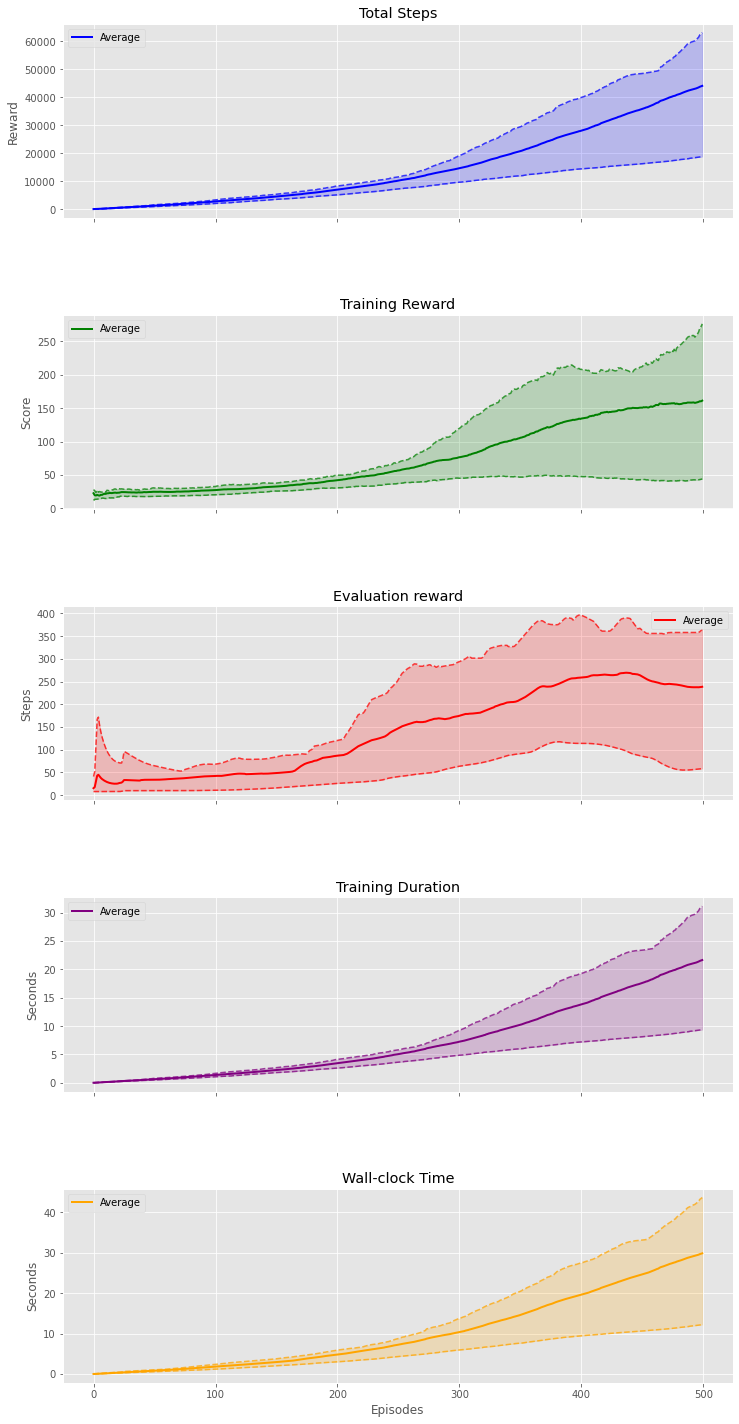

In [11]:
reward_max, steps_max, eval_score_max, train_time_max, wall_clock_max = np.max(reinforce_results, axis=0).T
reward_min, steps_min, eval_score_min, train_time_min, wall_clock_min = np.min(reinforce_results, axis=0).T
reward_avg, steps_avg, eval_score_avg, train_time_avg, wall_clock_avg = np.mean(reinforce_results, axis=0).T
episode_indices = np.arange(len(reward_avg))

plt.style.use('ggplot')  
fig, plot_areas = plt.subplots(5, 1, figsize=(12, 25), sharex='col')
fig.subplots_adjust(hspace=0.5)  
colors = ['blue', 'green', 'red', 'purple', 'orange']
titles = ['Total Steps','Training Reward', 'Evaluation reward',  'Training Duration', 'Wall-clock Time']
y_labels = ['Reward', 'Score', 'Steps', 'Seconds', 'Seconds']
data_max = [reward_max, steps_max, eval_score_max, train_time_max, wall_clock_max]
data_min = [reward_min, steps_min, eval_score_min, train_time_min, wall_clock_min]
data_avg = [reward_avg, steps_avg, eval_score_avg, train_time_avg, wall_clock_avg]

# Generate plots
for ax, title, color, max_data, min_data, avg_data, y_label in zip(plot_areas, titles, colors, data_max, data_min, data_avg, y_labels):
    ax.plot(max_data, linestyle='--', color=color, alpha=0.75)
    ax.plot(min_data, linestyle='--', color=color, alpha=0.75)
    ax.plot(avg_data, label='Average', color=color, linewidth=2)
    ax.fill_between(episode_indices, min_data, max_data, color=color, alpha=0.2)
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.legend()

plot_areas[-1].set_xlabel('Episodes')
plt.show()